In [1]:
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from time import time
from tqdm import tqdm

import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

device = torch.device('cuda' if (torch.cuda.is_available()) else "cpu")
print(device)

cpu


### ARN MODEL

In [2]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test(net,img_size=32):
    def unpack(x):
        if isinstance(x,tuple):
            return [unpack(y) for y in x]
        else:
            return list(x.size())
        
    x = torch.randn(1,1,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {}".format(unpack(x), unpack(y), count_parameters(net)))

In [4]:
class Generator(nn.Module):
    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28, z_dim=32):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2, track_running_stats = False),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False)
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, self.z_dim)
        self.fc22 = nn.Linear(512, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x);
        h = self.fc1(conv.view(-1, 1024))
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        deconv_input = deconv_input.view(-1,1024,1,1)
        
        return self.decoder(deconv_input)

    def forward(self, x, t=1):
        z, mu, logvar = self.encode(x)

        logits = self.decode(z)
        
        sample = self.sample_bernoulli(logits,t)

        return logits, mu, logvar, sample
    

    def sample_bernoulli(self, logits, t):
        return gumbel_sigmoid(logits, t)


In [5]:
m = Generator()


test(m,28)

Input: [1, 1, 28, 28]; Output: [[1, 1, 28, 28], [1, 32], [1, 32], [1, 1, 28, 28]]; N. of params: 15818304


In [6]:
class Discriminator(nn.Module):

    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.ReLU(inplace=True)
        )

        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.LayerNorm(512),
            
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.LayerNorm(256),
            
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.LayerNorm(128),
            
            nn.Linear(128, 1)
        )

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  

    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,1024)
        x = self.classifier(x)
        x = x.squeeze(1)
        return self.sigmoid(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




In [7]:
m = Discriminator()

test(m,28)

Input: [1, 1, 28, 28]; Output: [1]; N. of params: 5313025


In [8]:
def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)

In [9]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)
        
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
        
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss

In [10]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        self.bern_crit = torch.nn.BCEWithLogitsLoss()
        

    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))
        

    def log_bernoulli_pdf(self, data, logits):
        targets = data.flatten()
        logprobs = logits.flatten()

        return -torch.mean((F.logsigmoid(logprobs)) - (1 - targets) * logprobs)

    
    def forward(self, true_data, fake_preds, logits, z_mean, z_logvar, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        kld = self.KLD(z_mean, z_logvar)
        log_p_data = self.log_bernoulli_pdf(true_data, logits)

        return gamma*log_p_y + log_p_data + beta*kld, log_p_y, log_p_data, kld


# Trainer

In [11]:
class AADNet(nn.Module):
    def __init__(self, device):
        super(AADNet, self).__init__()
        self.device = device

        self.D = Discriminator().to(self.device)
        self.G = Generator().to(self.device)

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        
        self.d_loss_criterion = DiscriminatorLoss()
        self.g_loss_criterion = GeneratorLoss()
        
        self.temperature = 1
        self.anneal = 0.9995
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        _, _, _, sampled_data = self.G(true_data, self.temperature)
        
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss_criterion(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, z_mean, z_logvar, sampled_data = self.G(true_data, self.temperature)
        noise_pred = self.D(sampled_data)

        gen_loss_batch, a, b, c = self.g_loss_criterion(true_data, noise_pred, logits, z_mean, z_logvar, self.temperature)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return gen_loss_batch, a, b, c

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal

    
    def train(self, data_loader, batch_size = 32, num_epochs = 10, step = 10, thresh = 0., lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        logpyes = np.zeros(num_epochs)
        logpdes = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                i = 0
                self.D.train()
                self.G.train()
                for batch, _ in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)
                    batch = (batch > thresh).float()

                    ### Train discriminator ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        g_loss, a, b, c = self.G_step(batch,step_count)

                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    logpyes[epoch] = logpyes[epoch]*(i/(i+1.)) + b.item()*(1./(i+1.)) 
                    logpdes[epoch] = logpdes[epoch]*(i/(i+1.)) + a.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + c.item()*(1./(i+1.))
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    if (i+1) % step == 0:
                        sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | Step [{:>3}/{}]| d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f}'
                              .format(epoch+1, num_epochs, i+1, total_steps, d_loss.item(), g_loss.item(), a.item(), b.item(), c.item(), real_score.mean().item(), fake_score.mean().item()))
                        sys.stdout.flush()
                        
                    i += 1
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return d_losses[:epoch], g_losses[:epoch], logpyes[:epoch], logpdes[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch]
       

In [12]:
print("[INFO] loading dataset...")

batch_size = 256
epochs = 100
rowcol = 784

transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

thresh = 0.3

[INFO] loading dataset...


In [13]:
model = AADNet(device)

In [15]:
model.D.load_state_dict(torch.load('./ARN_D_MNIST.ckpt', map_location=torch.device(device)))
model.G.load_state_dict(torch.load('./ARN_G_MNIST.ckpt', map_location=torch.device(device)))

<All keys matched successfully>

### Model VAE

In [16]:
class VAE(nn.Module):
    def __init__(self, p_dims, q_dims=None, ):
        super(VAE, self).__init__()

        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        
        self.init_weights()        
        

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            nn.init.xavier_normal_(layer.weight)

        for layer in self.p_layers:
            nn.init.xavier_normal_(layer.weight)
        
        
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar
    
    
    def encode(self, input):
        h = input
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.relu(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps.mul(std).add_(mu)


    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.relu(h)

        return torch.sigmoid(h)

    
    def generate(self,n_samples=1):
        
        device = next(self.parameters()).device
        
        with torch.no_grad():
            z = torch.randn((n_samples,self.p_dims[0])).to(device)
            return self.decode(z)

In [17]:
vae_model = VAE(p_dims=[2,256,784]).to(device)

In [18]:
vae_model.load_state_dict(torch.load('./VAE.ckpt', map_location=torch.device(device)))

<All keys matched successfully>

In [19]:
def plot(real, real_bin, fake, prob, real_scores, fake_scores, num_images = 10):
    real = real.numpy()
    real_bin = real_bin.numpy()    
    fake = fake.numpy()
    prob = prob.numpy()
    fig = plt.figure(figsize=(30, 15))
#    fig.tight_layout(pad=3.0)
    for i in range(num_images):
        # display original images
        ax = plt.subplot(4, num_images, i + 1)
        plt.imshow(real[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplots_adjust(hspace=0.5)
        
        # display probs
        ax = plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(prob[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplots_adjust(hspace=0.5)

        # display original images (binarized)
        ax = plt.subplot(4, num_images, i + 1 + 2*num_images)
        plt.imshow(real_bin[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'P(normal)={real_scores[i].item():.2f}', fontsize = 20)
        plt.subplots_adjust(hspace=0.5)

        # display encoded images
        ax = plt.subplot(4, num_images, i + 1 + 3*num_images)
        plt.imshow(fake[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'P(normal)={fake_scores[i].item():.2f}', fontsize = 20)
        plt.subplots_adjust(hspace=0.5)
        
    plt.show()

In [20]:
iterator = iter(test_loader)

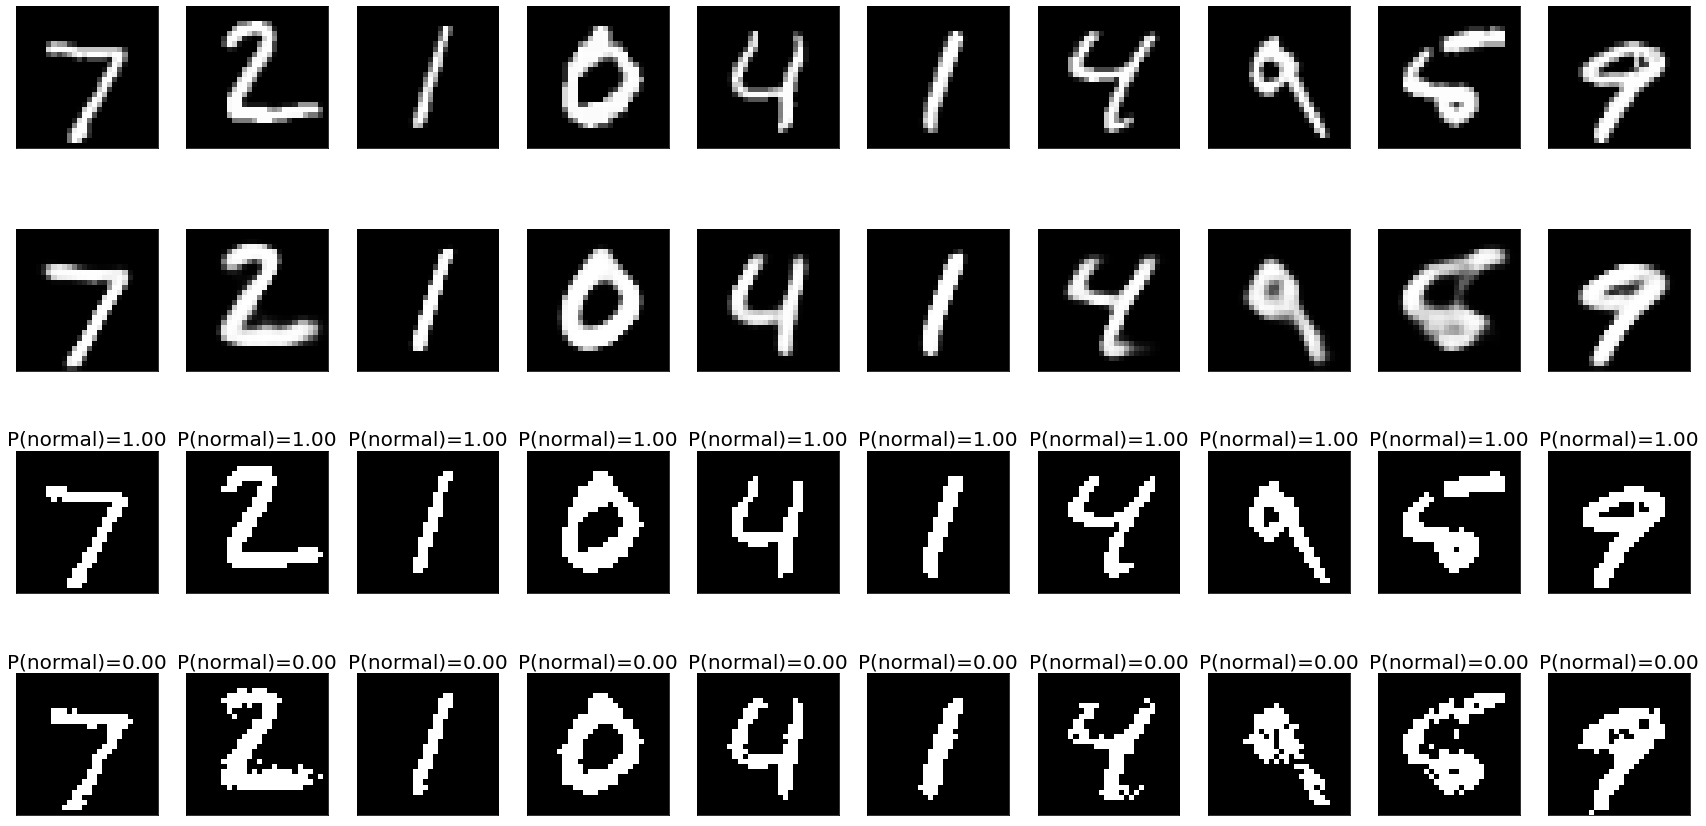

In [21]:
batch, _ = iterator.next()
batch = batch.to(device)

model.G.eval()

with torch.no_grad():
    batch_bin = (batch > thresh).float()
    logits,_, _, fake = model.G(batch_bin)
    probs = torch.sigmoid(logits)
    
    
    real_sc = model.D(batch_bin)
    fake_sc = model.D(fake)
    
    plot(batch.cpu(), batch_bin.cpu(), fake.cpu(), probs.cpu(), real_sc.cpu(), fake_sc.cpu())

In [22]:
model.G.eval()
i = 0

for batch, label in test_loader:
    batch = batch.to(device)

    with torch.no_grad():
        batch_bin = (batch > thresh).float()
        logits,_, _, fake = model.G(batch_bin)
        probs = torch.sigmoid(logits)
    
    real_sc = model.D(batch_bin)
    fake_sc = model.D(fake)
    
    if i == 0:
        true_data = batch.cpu().numpy()
        gen_data = fake.cpu().numpy()
        labels = label.numpy()
    else:
        true_data = np.concatenate((true_data, batch.cpu().numpy()))
        gen_data = np.concatenate((gen_data, fake.cpu().numpy()))
        labels = np.concatenate((labels, label.numpy()))
        
    i += 1

In [23]:
gen_data.shape

(10000, 1, 28, 28)

In [24]:
import pandas as pd

In [25]:
def plot_latent(model, test_loader, colors = None, mark = 'o', alpha = 1, all_train = False, reshape = True):
    
    import matplotlib

    matplotlib.rc('xtick', labelsize=13) 
    matplotlib.rc('ytick', labelsize=13) 
    
    model.eval()
    # display a 2D plot of the digit classes in the latent space
    with torch.no_grad():
        for i, (images, true_labels) in enumerate(test_loader):   
            images = images.to(device)
            if reshape:
                images = images.reshape(-1, 28*28)  
            images = (images > thresh).float()


            mu,logvar = model.encode(images)
            
            if i == 0:
                z_mean = model.reparameterize(mu,logvar).cpu() 
                y_test_real = true_labels
            else:
                z_mean = torch.cat([z_mean,
                                    model.reparameterize(mu,logvar).detach().cpu()
                                   ]
                                   ,axis = 0)
                # z.cpu()
                y_test_real = torch.cat([y_test_real,true_labels],axis = 0)
                
    if all_train:
        col = {0:'coral', 1:'limegreen', 2:'royalblue', 3:'slateblue', 4:'orchid', 5:'palevioletred', 6:'chocolate', 7:'olive', 8:'palegreen', 9:'teal'}
        y_test_real = pd.DataFrame(y_test_real, columns = ['labels'])
        
        colors = y_test_real['labels'].map(col)
        
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=colors, marker = mark, alpha = alpha)

In [26]:
x_test_gen = gen_data
y_test_gen = np.array([20] * gen_data.shape[0])

test_dataset_1 = torch.utils.data.TensorDataset(torch.tensor(true_data), torch.tensor(labels))
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size = batch_size)

test_dataset_gen = torch.utils.data.TensorDataset(torch.tensor(x_test_gen), torch.tensor(y_test_gen))
test_loader_gen = torch.utils.data.DataLoader(test_dataset_gen, batch_size = batch_size)

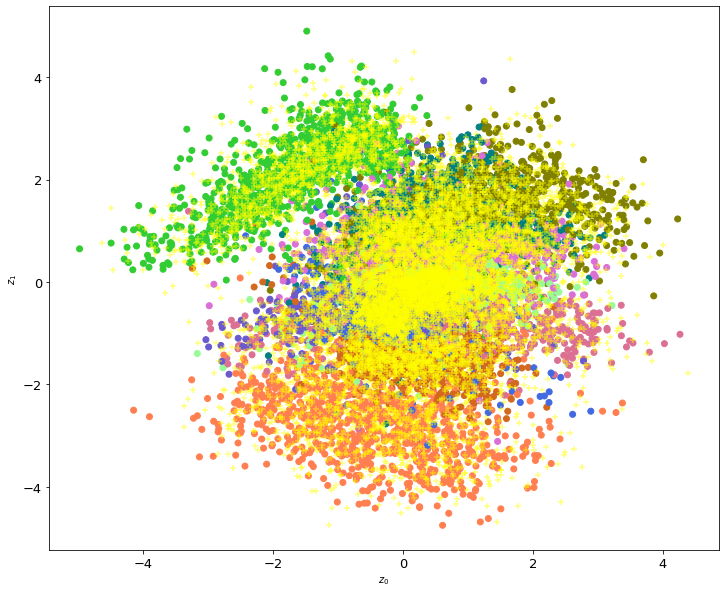

In [27]:
plt.figure(figsize=(12, 10))
plot_latent(vae_model, test_loader_1, all_train=True)
plot_latent(vae_model, test_loader_gen, colors=['yellow'], mark='+', alpha = 0.5)

plt.xlabel('$z_{0}$')
plt.ylabel('$z_{1}$')
plt.show()

In [28]:
n_sam = 20
x_test_1 = true_data[:n_sam]
x_test_2 = gen_data[:n_sam]

y_test_1 = np.array([n_sam] * true_data[:n_sam].shape[0])
y_test_2 = np.array([2*n_sam] * gen_data[:n_sam].shape[0])

test_dataset_1 = torch.utils.data.TensorDataset(torch.tensor(x_test_1), torch.tensor(y_test_1))
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size = batch_size)

test_dataset_2 = torch.utils.data.TensorDataset(torch.tensor(x_test_2), torch.tensor(y_test_2))
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size = batch_size)

x_test = true_data[n_sam:]
y_test = labels[n_sam:]
test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(y_test))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

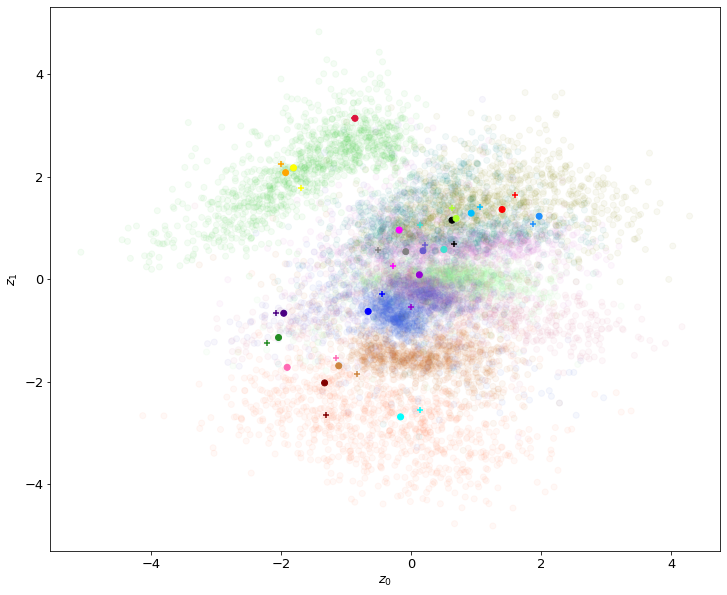

In [29]:
colors = ['red', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'black', 'gray', 'darkviolet', 'dodgerblue', 
          'maroon', 'peru', 'greenyellow', 'hotpink', 'crimson', 'forestgreen', 'slateblue', 'deepskyblue', 'indigo', 'turquoise']
plt.figure(figsize=(12, 10))
plot_latent(vae_model, test_loader, all_train=True, alpha = 0.05)

plot_latent(vae_model, test_loader_1, colors, 'o')
plot_latent(vae_model, test_loader_2, colors, '+')

plt.xlabel('$z_{0}$', fontsize = 13)
plt.ylabel('$z_{1}$', fontsize = 13)
#plt.savefig('mnist_latent_VAE_20.pdf')
plt.show()

In [30]:
n_sam = 10
x_test_1 = true_data[:n_sam]
x_test_2 = gen_data[:n_sam]

y_test_1 = np.array([n_sam] * true_data[:n_sam].shape[0])
y_test_2 = np.array([2*n_sam] * gen_data[:n_sam].shape[0])

test_dataset_1 = torch.utils.data.TensorDataset(torch.tensor(x_test_1), torch.tensor(y_test_1))
test_loader_1 = torch.utils.data.DataLoader(test_dataset_1, batch_size = batch_size)

test_dataset_2 = torch.utils.data.TensorDataset(torch.tensor(x_test_2), torch.tensor(y_test_2))
test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size = batch_size)

x_test = true_data[n_sam:]
y_test = labels[n_sam:]
test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test), torch.tensor(y_test))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size)

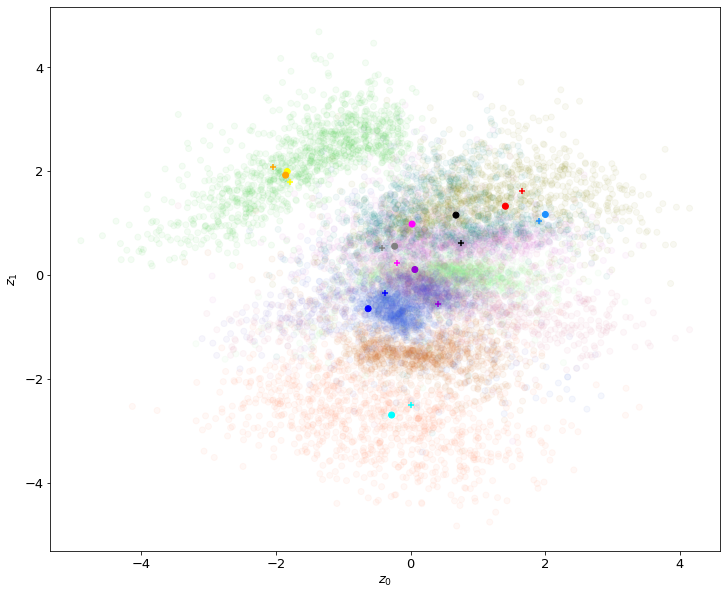

In [31]:
colors = ['red', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'black', 'gray', 'darkviolet', 'dodgerblue']
plt.figure(figsize=(12, 10))
plot_latent(vae_model, test_loader, all_train=True, alpha = 0.05)

plot_latent(vae_model, test_loader_1, colors, 'o')
plot_latent(vae_model, test_loader_2, colors, '+')

plt.xlabel('$z_{0}$', fontsize = 13)
plt.ylabel('$z_{1}$', fontsize = 13)
#plt.savefig('mnist_latent_VAE.pdf')
plt.show()